# Outlier Analysis

Set legal limits: What happens to the values?

Analyse the outliers: count, distribution, distribution on quality

# Config Notebook

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import yaml

from scipy import stats 
import pingouin as pg

from sklearn.preprocessing import MinMaxScaler

# import pyarrow as pa

In [2]:
# config packages
pd.options.mode.copy_on_write = "warn"

In [3]:
# load project config
with open("../config/config.yaml", "r") as file:
    config = yaml.safe_load(file)
config

{'data_path_wine_red': 'data/wine+quality/winequality-red.csv',
 'data_path_wine_white': 'data/wine+quality/winequality-white.csv'}

In [4]:
# useful constants
%run ../src/constants.py

# Import

In [5]:
# NOTE - Keep two data frames if data is actually separate
# wine_r = pd.read_csv('data//wine+quality//winequality-red.csv', sep=';', dtype_backend=) # pyarrow enhanced data frame
wine_w = pd.read_parquet('../data/processed/wine_w.parquet')
wine_r = pd.read_parquet('../data/processed/wine_r.parquet')
wine_w_orig = pd.read_parquet('../data/processed/wine_w_orig.parquet')
wine_r_orig = pd.read_parquet('../data/processed/wine_r_orig.parquet')


In [6]:
wine_w.head()

,ph,fixed_acidity,volatile_acidity,citric_acid,chlorides,total_sulfur_dioxide,free_sulfur_dioxide,sulphates,residual_sugar,density,alcohol,quality,color,quality_label,total_sulfur_dioxide_above_eu_limit,volatile_acid_above_eu_limit,sulfur_dioxide_ratio,acidity_ratio,total_acidity,input_outlier_count
0,3.00,7.0,0.27,0.36,0.045,170.0,45.0,0.45,20.7,1.0010,8.8,6,white,medium,False,False,0.264706,0.038571,7.63,0
1,3.30,6.3,0.30,0.34,0.049,132.0,14.0,0.49,1.6,0.9940,9.5,6,white,medium,False,False,0.106061,0.047619,6.94,0
2,3.26,8.1,0.28,0.40,0.050,97.0,30.0,0.44,6.9,0.9951,10.1,6,white,medium,False,False,0.309278,0.034568,8.78,0
3,3.19,7.2,0.23,0.32,0.058,186.0,47.0,0.40,8.5,0.9956,9.9,6,white,medium,False,False,0.252688,0.031944,7.75,0
6,3.18,6.2,0.32,0.16,0.045,136.0,30.0,0.47,7.0,0.9949,9.6,6,white,medium,False,False,0.220588,0.051613,6.68,0


# Transform for compatibility (maybe outdated)

In [7]:
wine_w_is_outlier = pd.read_parquet('../data/processed/wine_w_is_outlier.parquet')
wine_w_is_outlier_any = wine_w.input_outlier_count > 0

In [8]:
wine_r_is_outlier = pd.read_parquet('../data/processed/wine_r_is_outlier.parquet')
wine_r_is_outlier_any = wine_r.input_outlier_count > 0

In [9]:
wine_w_illegal = wine_w.total_sulfur_dioxide_above_eu_limit | wine_w.volatile_acid_above_eu_limit
wine_r_illegal = wine_r.total_sulfur_dioxide_above_eu_limit | wine_r.volatile_acid_above_eu_limit

# Boundaries: Legal Limits

In [10]:
wine_w.head()

,ph,fixed_acidity,volatile_acidity,citric_acid,chlorides,total_sulfur_dioxide,free_sulfur_dioxide,sulphates,residual_sugar,density,alcohol,quality,color,quality_label,total_sulfur_dioxide_above_eu_limit,volatile_acid_above_eu_limit,sulfur_dioxide_ratio,acidity_ratio,total_acidity,input_outlier_count
0,3.00,7.0,0.27,0.36,0.045,170.0,45.0,0.45,20.7,1.0010,8.8,6,white,medium,False,False,0.264706,0.038571,7.63,0
1,3.30,6.3,0.30,0.34,0.049,132.0,14.0,0.49,1.6,0.9940,9.5,6,white,medium,False,False,0.106061,0.047619,6.94,0
2,3.26,8.1,0.28,0.40,0.050,97.0,30.0,0.44,6.9,0.9951,10.1,6,white,medium,False,False,0.309278,0.034568,8.78,0
3,3.19,7.2,0.23,0.32,0.058,186.0,47.0,0.40,8.5,0.9956,9.9,6,white,medium,False,False,0.252688,0.031944,7.75,0
6,3.18,6.2,0.32,0.16,0.045,136.0,30.0,0.47,7.0,0.9949,9.6,6,white,medium,False,False,0.220588,0.051613,6.68,0


## Legal Limits on White Wines

In [11]:
# illegal white wines
wine_w_illegal_counts = wine_w[wine_w_illegal].quality.value_counts().sort_index()
wine_w_illegal_counts

quality
3      5
4      6
5     96
6    102
7      5
8      1
Name: count, dtype: int64

In [12]:
# count illegal wines
print(wine_w.total_sulfur_dioxide_above_eu_limit.sum())
print(wine_w.volatile_acid_above_eu_limit.sum())

215
0


Text(0, 0.5, '')

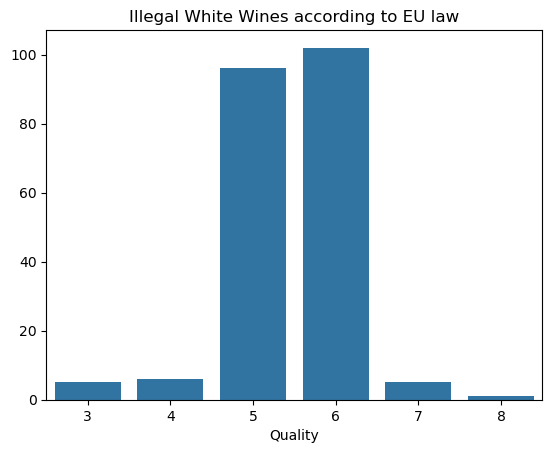

In [13]:
# plot illegal white wines
ax = sns.barplot(wine_w_illegal_counts)

ax.set_title('Illegal White Wines according to EU law')
ax.set_xlabel('Quality')
ax.set_ylabel('')

In [14]:
wine_w[wine_w_illegal & (wine_w.quality > 6)]

,ph,fixed_acidity,volatile_acidity,citric_acid,chlorides,total_sulfur_dioxide,free_sulfur_dioxide,sulphates,residual_sugar,density,alcohol,quality,color,quality_label,total_sulfur_dioxide_above_eu_limit,volatile_acid_above_eu_limit,sulfur_dioxide_ratio,acidity_ratio,total_acidity,input_outlier_count
432,3.18,7.4,0.155,0.34,0.045,214.0,73.5,0.61,2.3,0.99340,9.9,7,white,high,True,False,0.343458,0.020946,7.895,0
1609,3.09,8.1,0.200,0.49,0.048,212.0,46.0,0.46,11.8,0.99680,10.0,7,white,high,True,False,0.216981,0.024691,8.790,0
1980,3.14,7.6,0.200,0.30,0.056,212.5,53.0,0.46,14.2,0.99900,8.9,8,white,exceptionel,True,False,0.249412,0.026316,8.100,0
2167,3.14,7.4,0.190,0.30,0.053,229.0,48.5,0.49,12.8,0.99860,9.1,7,white,high,True,False,0.211790,0.025676,7.890,0
2175,3.14,7.4,0.190,0.30,0.053,212.0,48.5,0.49,12.8,0.99860,9.1,7,white,high,True,False,0.228774,0.025676,7.890,0
2770,3.26,6.4,0.440,0.44,0.048,228.0,29.0,0.54,14.4,0.99955,8.8,7,white,high,True,False,0.127193,0.068750,7.280,0


## Legal Limits on Red Wine

In [15]:
wine_r_illegal_counts = wine_r[wine_r_illegal].quality.value_counts().sort_index()
wine_r_illegal_counts

quality
3    1
5    3
6    1
7    2
Name: count, dtype: int64

In [16]:
# count illegal wines 
print(wine_r.total_sulfur_dioxide_above_eu_limit.sum())
print(wine_r.volatile_acid_above_eu_limit.sum())

3
4


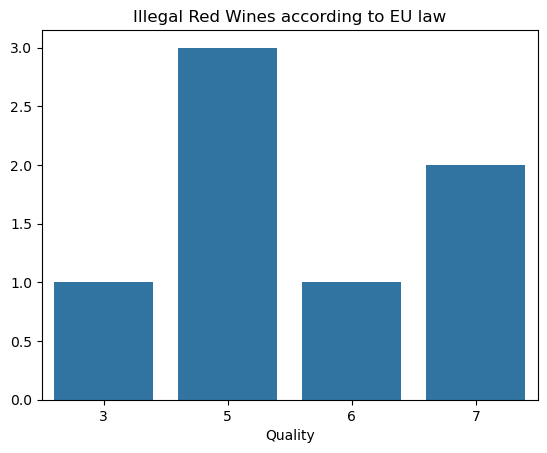

In [17]:
# plot illegal red wines
ax = sns.barplot(wine_r_illegal_counts)

ax.set_title('Illegal Red Wines according to EU law')
ax.set_xlabel('Quality')
ax.set_ylabel('')

plt.show()

## Conclusions on Illegal Wines in the EU
* There are many illegal white wines and only a few illegal red wines.
* The limits are only useful if we consider selling / dealing with wines in the EU.
* It is unclear what sweet wines are and if those limits apply to any of the wines in the data set.
* What are the sales of vinho verde outside of the EU?

Result: The illegal wines should be kept in the data set.

# Univariate Outlier Detection

## White Wine Outliers

### Outliers per input quantity

In [18]:
# Outlier Wines
# TODO how to format table?
print('White wines with at least ')
print('\tone outlier value\t', sum(wine_w_is_outlier.T.sum()>0))
print('\ttwo outlier values\t', sum(wine_w_is_outlier.T.sum()>1))
print('\tthree outlier values\t', sum(wine_w_is_outlier.T.sum()>2))

White wines with at least 
	one outlier value	 505
	two outlier values	 74
	three outlier values	 5


In [19]:
outlier_per_quantity = wine_w_is_outlier.sum().sort_values(ascending=False)

print('Count of outliers per input quantity\n', outlier_per_quantity)
print()
print('Count of outliers in input quantities\n', outlier_per_quantity.sum())
print()
print('Count of White wines with some sort of outlier input values', wine_w_is_outlier_any.sum())

Count of outliers per input quantity
 citric_acid             219
volatile_acidity        127
fixed_acidity           102
sulphates                84
free_sulfur_dioxide      40
total_sulfur_dioxide     14
ph                        0
chlorides                 0
residual_sugar            0
density                   0
alcohol                   0
dtype: int64

Count of outliers in input quantities
 586

Count of White wines with some sort of outlier input values 531


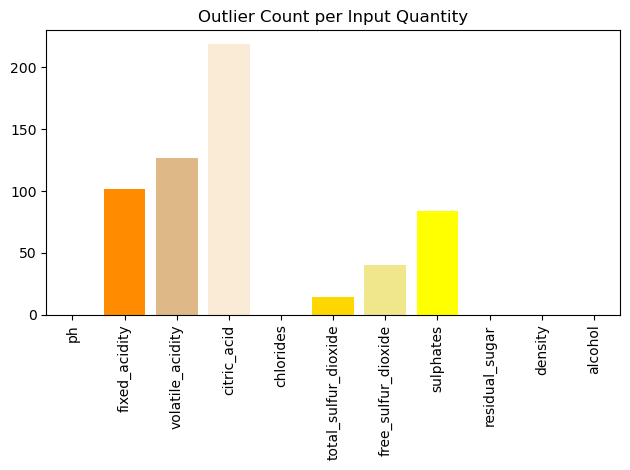

In [20]:
ax = sns.barplot(outlier_per_quantity[all_inputs])

for bars in ax.containers:
    for bar, input in zip(bars, all_inputs):
        bar.set_facecolor(input_param_colors[input])

ax.tick_params(axis='x', labelrotation=90)

ax.set_title('Outlier Count per Input Quantity')

plt.tight_layout()
plt.show()

### Outliers per Quality 

In [21]:
# TODO redo this analysis! The outliers have to be calculated among the quality groups, like in the boxplot
outliers_per_quality = pd.concat(
          [
              wine_w.quality.value_counts().rename('total_count'),
              wine_w[wine_w_is_outlier_any].quality.value_counts().rename('outlier_count'),
              (wine_w[wine_w_is_outlier_any].quality.value_counts() / wine_w.quality.value_counts()),
          ],
          axis=1,
          verify_integrity=True
      #     right_index=True, left_index=True
          ).sort_index().rename(columns={'count':'outlier_fraction'})

outliers_per_quality['quality'] = outliers_per_quality.index

print('Fraction of White wines with some sort of outlier input values split by', '\n',
      outliers_per_quality
    )

Fraction of White wines with some sort of outlier input values split by 
          total_count  outlier_count  outlier_fraction  quality
quality                                                       
3                 20             10          0.500000        3
4                153             60          0.392157        4
5               1175            200          0.170213        5
6               1788            189          0.105705        6
7                689             52          0.075472        7
8                131             19          0.145038        8
9                  5              1          0.200000        9


c:\Users\olive\anaconda3\envs\base_data_analysis\Lib\site-packages\seaborn\categorical.py:2761: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try countplot
  warnings.warn(msg, UserWarning)


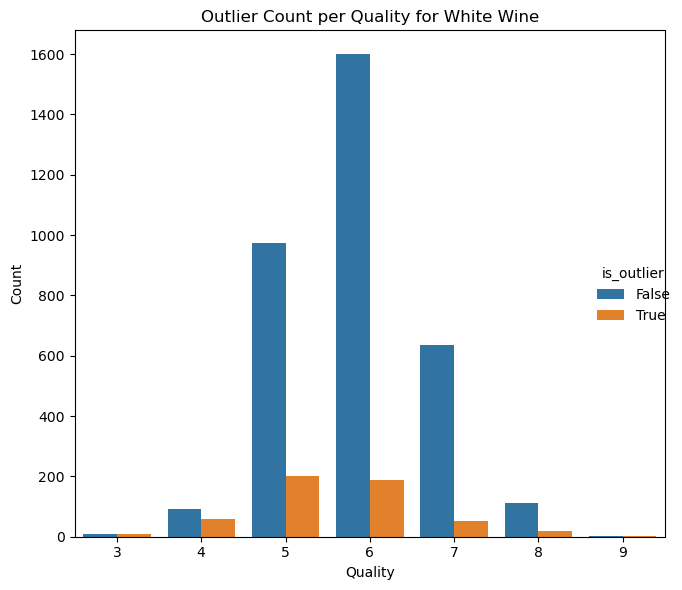

In [22]:
# TODO this graph has to be refined for the presentation!
# TODO there might be a better plot than this
# fig, ax = plt.subplots(1, 1, figsize=(8,6))
wine_w['is_outlier'] = wine_w_is_outlier_any

cat = sns.catplot(wine_w, x='quality', hue='is_outlier', kind='count', height=6, aspect=1, ax=ax)

ax = plt.gca()
fig = plt.gcf()

ax.set_title('Outlier Count per Quality for White Wine')
ax.set_xlabel('Quality')
ax.set_ylabel('Count')

sns.despine(left = False, bottom = False, top = False, right=False) # this would remove all spines

plt.tight_layout()

plt.show()

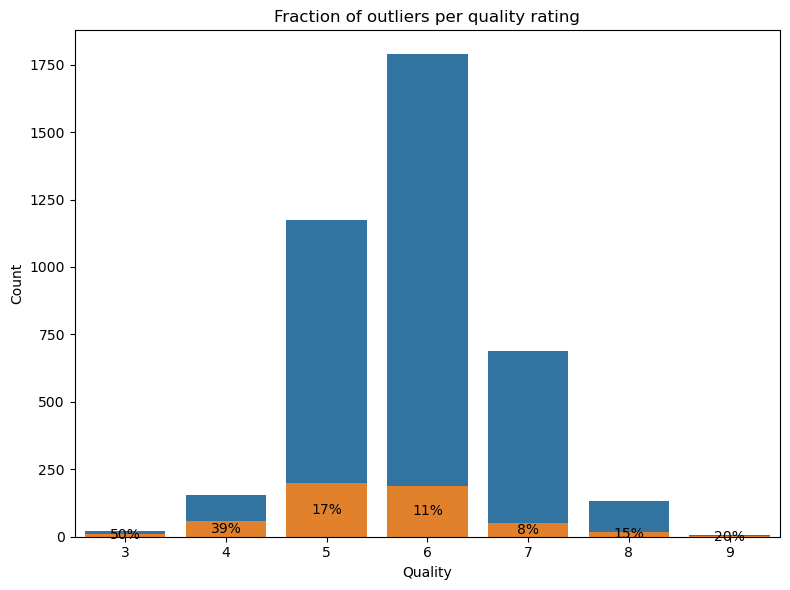

In [23]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots(1, 1, figsize=(8,6))

bar1 = sns.barplot(outliers_per_quality, x=outliers_per_quality.index, y='total_count')
bar2 = sns.barplot(outliers_per_quality, x=outliers_per_quality.index, y='outlier_count')

ax = plt.gca()

# settings ax[0]
ax.set_title('Fraction of outliers per quality rating')

ax.set_xlabel('Quality')

# ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.set_ylabel('Count')
# ax.set_yscale('log')

# label data
bar2.bar_label(
    bar2.containers[1],
    labels=[f'{value:.0%}' for value in outliers_per_quality.outlier_fraction],
    #fmt=f'{value:.0%}'
    label_type='center'
    )

plt.tight_layout()

In [24]:
# pivot table
# how are the outliers in a quantity distributed over quality? many outliers per input quantity per quality

# merge is_outlier with wine qualities to count values by summing up
is_outlier_quality = pd.merge(wine_w_is_outlier, wine_w.loc[:, 'quality'], left_index=True, right_index=True)

# transform with pivot table
outlier_per_quality = pd.pivot_table(is_outlier_quality, values=all_inputs, index='quality', aggfunc='sum')[all_inputs]
outlier_per_quality / outlier_per_quality.sum()

,ph,fixed_acidity,volatile_acidity,citric_acid,chlorides,total_sulfur_dioxide,free_sulfur_dioxide,sulphates,residual_sugar,density,alcohol
quality,,,,,,,,,,,
3,NaN,0.049020,0.023622,0.000000,NaN,0.214286,0.100,0.000000,NaN,NaN,NaN
4,NaN,0.137255,0.259843,0.100457,NaN,0.142857,0.050,0.047619,NaN,NaN,NaN
5,NaN,0.421569,0.401575,0.470320,NaN,0.500000,0.375,0.154762,NaN,NaN,NaN
6,NaN,0.333333,0.267717,0.374429,NaN,0.142857,0.375,0.500000,NaN,NaN,NaN
7,NaN,0.058824,0.047244,0.054795,NaN,0.000000,0.100,0.297619,NaN,NaN,NaN
8,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.000,0.000000,NaN,NaN,NaN
9,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.000,0.000000,NaN,NaN,NaN


In [25]:
# distribution of outliers along quality NOTE does not really make sense to calculate this, was still fun though!
# pivot = pd.pivot_table(is_outlier_quality, values=all_inputs, index='quality', aggfunc='sum')[all_inputs]
# is_outlier_quality[all_inputs].sum()
# for id, val in is_outlier_quality[all_inputs].sum().items():
#     pivot.loc[:, id] /= val
# pivot

### Outliers per Quality Label

In [26]:
wine_w.columns

Index(['ph', 'fixed_acidity', 'volatile_acidity', 'citric_acid', 'chlorides',
       'total_sulfur_dioxide', 'free_sulfur_dioxide', 'sulphates',
       'residual_sugar', 'density', 'alcohol', 'quality', 'color',
       'quality_label', 'total_sulfur_dioxide_above_eu_limit',
       'volatile_acid_above_eu_limit', 'sulfur_dioxide_ratio', 'acidity_ratio',
       'total_acidity', 'input_outlier_count', 'is_outlier'],
      dtype='object')

In [27]:
# no quality label defined here, move this section, if needed

stomper = pd.merge(
          wine_w.quality_label.value_counts(),
          (wine_w[wine_w.is_outlier].quality_label.value_counts() / wine_w.quality_label.value_counts()),
          right_index=True, left_index=True
          ).sort_index().rename(columns={'count_x':'total_count', 'count_y':'fraction'})

print('Fraction of White wines with some sort of outlier input values split by', '\n', 
      stomper
    )

Fraction of White wines with some sort of outlier input values split by 
                total_count  fraction
quality_label                       
low                   1348  0.200297
medium                1788  0.105705
high                   689  0.075472
exceptionel            136  0.147059


In [28]:
# quality of outliers vs. non-outliers
wine_w.groupby(by=['quality_label','is_outlier']).agg({'quality_label':'count', 'quality':'mean'})

C:\Users\olive\AppData\Local\Temp\ipykernel_32720\829496094.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wine_w.groupby(by=['quality_label','is_outlier']).agg({'quality_label':'count', 'quality':'mean'})


quality_label   quality
quality_label is_outlier                         
low           False                1078  4.895176
              True                  270  4.703704
medium        False                1599  6.000000
              True                  189  6.000000
high          False                 637  7.000000
              True                   52  7.000000
exceptionel   False                 116  8.034483
              True                   20  8.050000

### Correlations

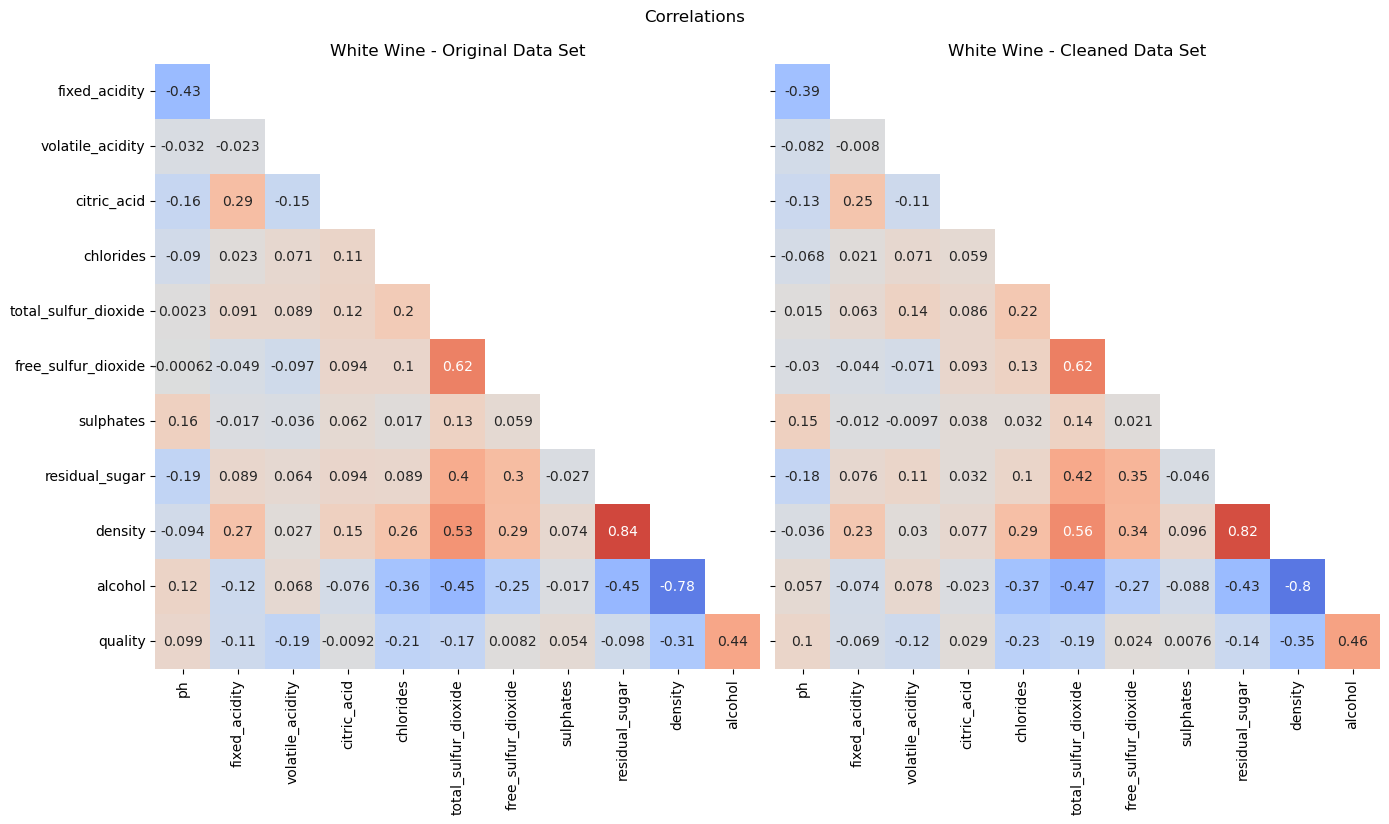

In [29]:
# Plot correlations of original and cleaned data set side by side
# TODO draw with color bar!

f, ax = plt.subplots(1, 2, figsize=(14, 8), sharex=True, sharey=True)

plt.suptitle('Correlations')

corr_w_plot         = wine_w.loc[wine_w.input_outlier_count == 0, all_columns].corr(numeric_only=True).drop(index='ph', columns='quality')
corr_w_orig_plot    = wine_w_orig[all_columns].corr(numeric_only=True).drop(index='ph', columns='quality')

mask = np.triu(np.ones_like(corr_w_plot, dtype=bool), k=1) # same for red wine

sns.heatmap(corr_w_orig_plot, mask=mask, annot=True, cmap='coolwarm', cbar=False, vmin=-1, vmax=1, square=True, ax=ax[0])
sns.heatmap(corr_w_plot, mask=mask, annot=True, cmap='coolwarm', cbar=False, vmin=-1, vmax=1, square=True, ax=ax[1])

ax[0].set_title('White Wine - Original Data Set')
ax[1].set_title('White Wine - Cleaned Data Set')


labels = [
    'Fixed Acidity', 'Volatile Acidity', 'Citric Acidity', 'Chlorides', 'Total Sulfur Dioxide', 'Free Sulfur Dioxide',
    'Sulphates', 'Residual Sugar', 'Density', 'Alcohol', 'Quality'
]

# ax[0].set_xticklabel(labels)
# ax[0].set_ylabel(labels)
# ax[1].set_xlabel(labels)
# ax[1].set_ylabel(labels)

plt.tight_layout()

### Conlusions on White Wine Outliers

- Outlier distribution in input values
  - There are many outliers in the acidity quantities; removing those reduces the correlation to quality in the correlation matrix!
  - pH and Free and Total Sulfur Dioxide have a considerable amount of outliers.
  - density, sugar, alcohol have only got a few outliers
  - What does this tell us about the statistics? Many outliers indicate 
    - a wide distribution -> bad statistics or simply a strongly varying quantity
- Outliers by Quality
  - The higher the quality the less outlier wines, i.e. the correlation between inputs and out seems to be more conclusive for the higher quality wines!
  - The average quality of high quality outliers is larger than the average quality of the normal data; it's the other way around for low quality.
  - This indicates that the low quality outliers should be removed, whereas the high quality outliers contain valuable information about good wine! 

### Some Questions

#### What do the outliers tell us about the sample?

The data set is a good representation for both testers and wines for quality rating:
- What does that mean?
  - A lot of tasteprofiles for both wines and tasters are included.
- What are hints on a good representation?
  - 1st level: normally distributed data
  - 2nd: level: Many values in values range
- Pros
  - What about the distribution of qualtiy? What does this tell us about the sample? 
    - If that is kind of normally distributed, then we will have a good sample.
    - For both red and white wines this is true.
- Cons
  - Univariate Analysis shows that the quantities do not show a normal distribution. Should they be normally distributed?
  - The data set seems to be very noisy.

#### How to handle the outliers?

- What is the meaning of an outlier?
  - It is a wine with an exceptional value in his respective group. 
  - Low quality: Something probably turned out bad along the production process: Growing, harvesting, fermenting, storing ...
  - High quality: there's something exceptional about the wine!
- remove outliers to reduce noise, but keep some of the funky parts
  - quality / taste is a very complex number and only relatively depends on the input quantities
  - Remove the funky parts of the data set, because we haven't got enough knowledge to make sense of the data!
  - Considering the many unknown variables of the system and the noise in the data a useful approach to make sense of the data is to get rid of this noise and reveal the main features of the data set.
  - Some outliers should be considered though, e.g. high quality wines.

## Red Wine Outliers

In [30]:
print('Red wines with at least ')
print('\tone outlier value\t', sum(wine_r_is_outlier.T.sum()>0))
print('\ttwo outlier values\t', sum(wine_r_is_outlier.T.sum()>1))
print('\tthree outlier values\t', sum(wine_r_is_outlier.T.sum()>2))

Red wines with at least 
	one outlier value	 340
	two outlier values	 101
	three outlier values	 26


In [31]:
outlier_per_quantity = wine_r_is_outlier.sum().sort_values(ascending=False)

print('Count of outliers per input quantity\n', outlier_per_quantity)
print()
print('Count of outliers in input quantities\n', outlier_per_quantity.sum())
print()
print('Count of Red Wines with some sort of outlier input values', wine_w_is_outlier_any.sum())

Count of outliers per input quantity
 residual_sugar          126
chlorides                87
sulphates                55
total_sulfur_dioxide     45
fixed_acidity            41
density                  35
ph                       28
free_sulfur_dioxide      26
volatile_acidity         19
alcohol                  12
citric_acid               1
dtype: int64

Count of outliers in input quantities
 475

Count of Red Wines with some sort of outlier input values 531


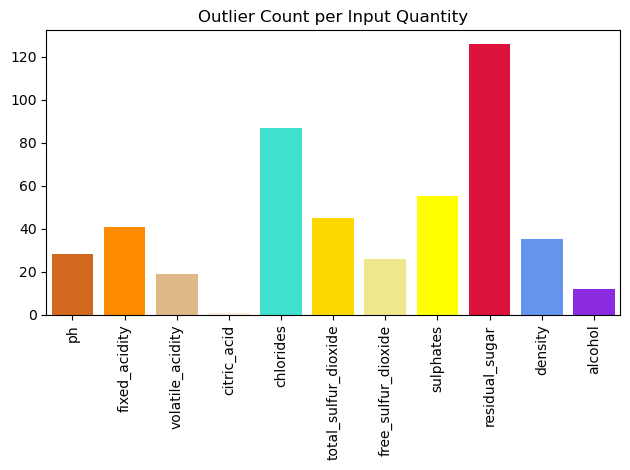

In [32]:
ax = sns.barplot(outlier_per_quantity[all_inputs])

for bars in ax.containers:
    for bar, input in zip(bars, all_inputs):
        bar.set_facecolor(input_param_colors[input])

ax.tick_params(axis='x', labelrotation=90)

ax.set_title('Outlier Count per Input Quantity')

plt.tight_layout()
plt.show()

In [33]:
# Outliers per Quality Rating
outliers_per_quality = pd.concat(
          [
              wine_r.quality.value_counts().rename('total_count'),
              wine_r[wine_r_is_outlier_any].quality.value_counts().rename('outlier_count'),
              (wine_r[wine_r_is_outlier_any].quality.value_counts() / wine_r.quality.value_counts()),
          ],
          axis=1,
          verify_integrity=True
      #     right_index=True, left_index=True
          ).sort_index().rename(columns={'count':'outlier_fraction'})

outliers_per_quality['quality'] = outliers_per_quality.index

print('Fraction of White wines with some sort of outlier input values split by', '\n',
      outliers_per_quality
    )

Fraction of White wines with some sort of outlier input values split by 
          total_count  outlier_count  outlier_fraction  quality
quality                                                       
3                 10              7          0.700000        3
4                 53             20          0.377358        4
5                577            143          0.247834        5
6                535            112          0.209346        6
7                167             52          0.311377        7
8                 17              6          0.352941        8


c:\Users\olive\anaconda3\envs\base_data_analysis\Lib\site-packages\seaborn\categorical.py:2761: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try countplot
  warnings.warn(msg, UserWarning)


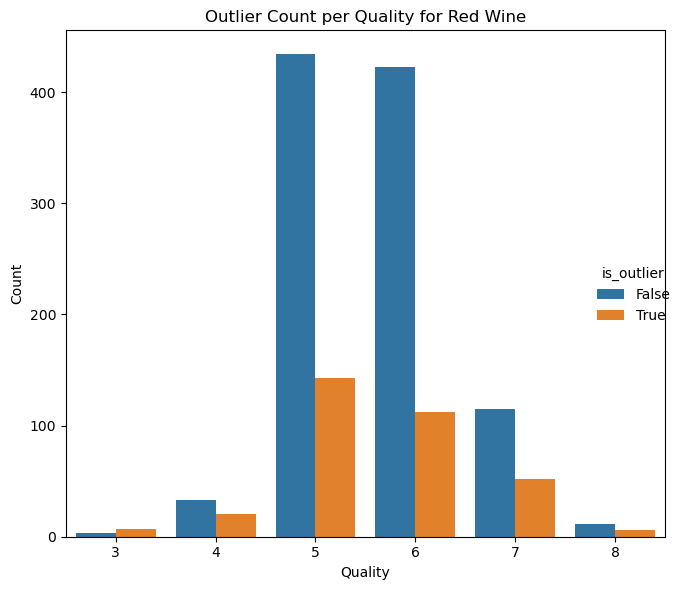

In [34]:
# TODO this graph has to be refined for the presentation!
# fig, ax = plt.subplots(1, 1, figsize=(8,6))
wine_r['is_outlier'] = wine_r_is_outlier_any

cat = sns.catplot(wine_r, x='quality', hue='is_outlier', kind='count', height=6, aspect=1, ax=ax)

ax = plt.gca()
fig = plt.gcf()

ax.set_title('Outlier Count per Quality for Red Wine')
ax.set_xlabel('Quality')
ax.set_ylabel('Count')

sns.despine(left = False, bottom = False, top = False, right=False) # this would remove all spines

plt.tight_layout()

plt.show()

In [35]:
# pivot table
# how are the outliers in a quantity distributed over quality? many outliers per input quantity per quality

# merge is_outlier with wine qualities to count values by summing up
is_outlier_quality = pd.merge(wine_r_is_outlier, wine_r.loc[:, 'quality'], left_index=True, right_index=True)

# transform with pivot table
outlier_per_quality = pd.pivot_table(is_outlier_quality, values=all_inputs, index='quality', aggfunc='sum')[all_inputs]
outlier_per_quality / outlier_per_quality.sum()

,ph,fixed_acidity,volatile_acidity,citric_acid,chlorides,total_sulfur_dioxide,free_sulfur_dioxide,sulphates,residual_sugar,density,alcohol
quality,,,,,,,,,,,
3,0.000000,0.000000,0.157895,0.0,0.045977,0.000000,0.000000,0.000000,0.015873,0.000000,0.000000
4,0.107143,0.024390,0.315789,1.0,0.045977,0.000000,0.000000,0.054545,0.071429,0.000000,0.000000
5,0.250000,0.317073,0.421053,0.0,0.459770,0.844444,0.576923,0.490909,0.420635,0.200000,0.083333
6,0.428571,0.463415,0.105263,0.0,0.367816,0.111111,0.269231,0.290909,0.285714,0.514286,0.333333
7,0.142857,0.170732,0.000000,0.0,0.080460,0.044444,0.153846,0.145455,0.190476,0.228571,0.416667
8,0.071429,0.024390,0.000000,0.0,0.000000,0.000000,0.000000,0.018182,0.015873,0.057143,0.166667


### Outliers per Quality Label

In [36]:
print('Fraction of Red Wines with some sort of outlier input values split by', '\n', 
      pd.merge(
          wine_r.quality_label.value_counts(),
          (wine_r[wine_r.is_outlier].quality_label.value_counts() / wine_r.quality_label.value_counts()),
          right_index=True, left_index=True
          ).sort_index().rename(columns={'count_x':'total_count', 'count_y':'fraction'})
    )

Fraction of Red Wines with some sort of outlier input values split by 
                total_count  fraction
quality_label                       
low                    640  0.265625
medium                 535  0.209346
high                   167  0.311377
exceptionel             17  0.352941


### Correlations

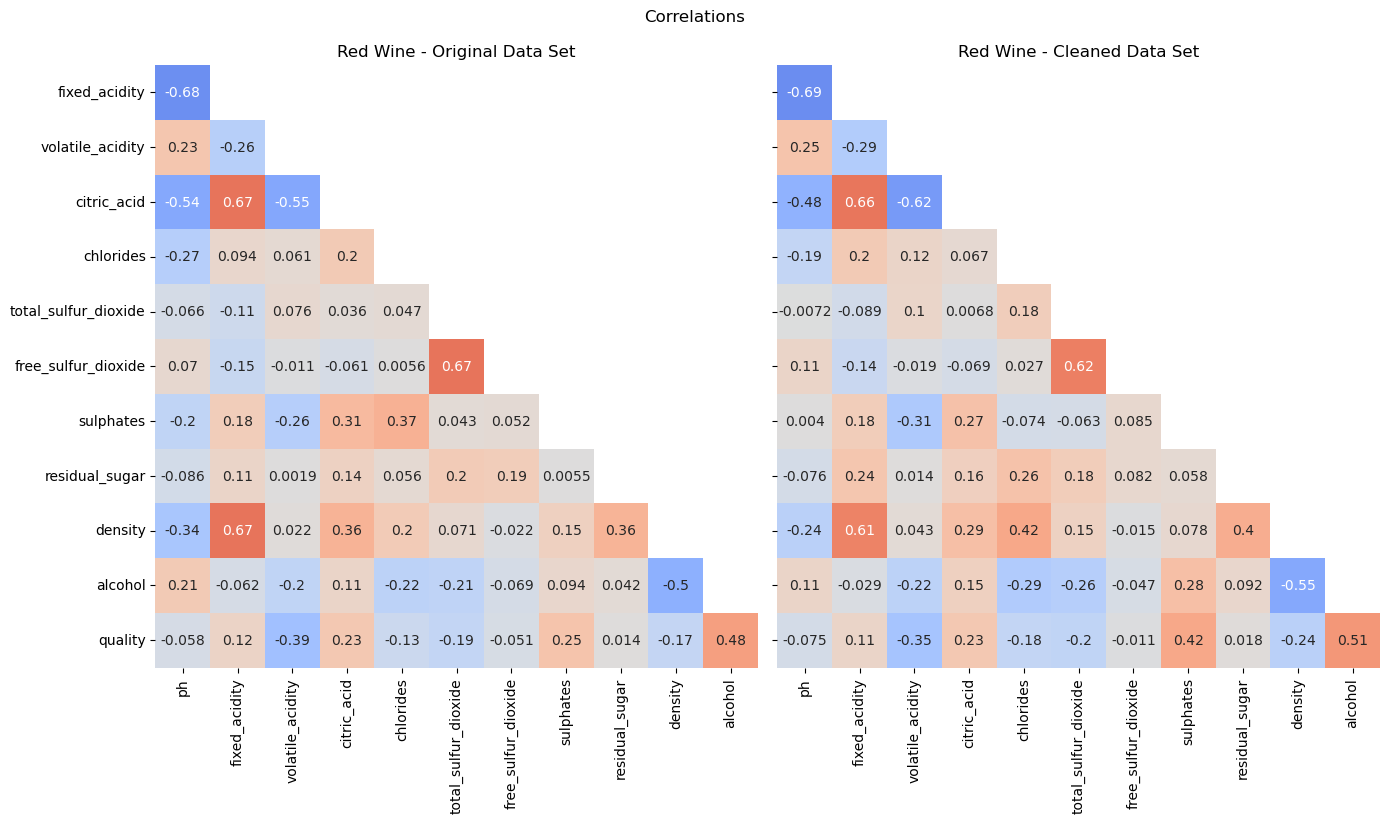

In [37]:
# Plot correlations of original and cleaned data set sid by side
# TODO draw with color bar!

f, ax = plt.subplots(1, 2, figsize=(14, 8), sharex=True, sharey=True)

plt.suptitle('Correlations')

corr_r_plot         = wine_r.loc[wine_r.input_outlier_count == 0, all_columns].corr(numeric_only=True).drop(index='ph', columns='quality')
corr_r_orig_plot    = wine_r_orig[all_columns].corr(numeric_only=True).drop(index='ph', columns='quality')

mask = np.triu(np.ones_like(corr_r_plot, dtype=bool), k=1) # same for red wine

sns.heatmap(corr_r_orig_plot, mask=mask, annot=True, cmap='coolwarm', cbar=False, vmin=-1, vmax=1, square=True, ax=ax[0])
sns.heatmap(corr_r_plot, mask=mask, annot=True, cmap='coolwarm', cbar=False, vmin=-1, vmax=1, square=True, ax=ax[1])

ax[0].set_title('Red Wine - Original Data Set')
ax[1].set_title('Red Wine - Cleaned Data Set')


labels = [
    'Fixed Acidity', 'Volatile Acidity', 'Citric Acidity', 'Chlorides', 'Total Sulfur Dioxide', 'Free Sulfur Dioxide',
    'Sulphates', 'Residual Sugar', 'Density', 'Alcohol', 'Quality'
]

# ax[0].set_xticklabel(labels)
# ax[0].set_ylabel(labels)
# ax[1].set_xlabel(labels)
# ax[1].set_ylabel(labels)

plt.tight_layout()

### Conclusions on Red Wine Outliers

- Removal has only a small effect on the quality correlations, except for sulphates!
- Quantities that show a different behaviour:
  - Chlorides have a completely different, more pronounced relation to other quantities.
    - more correlated to Fixed and Volatile Acidity, but much less to Citric Acid.
    - more correlated to Sulfur Dioxide, Residual Sugar, Density
    - much less correlated to Sulphates
  - Free Sulfur Dioxide is less related to other quantities
  - Sulphates are
    - more correlated to alcohol
    - less to density, pH, Chlorides

# Multivariate Outlier Detection

In [42]:
wine_w[all_inputs]

,ph,fixed_acidity,volatile_acidity,citric_acid,chlorides,total_sulfur_dioxide,free_sulfur_dioxide,sulphates,residual_sugar,density,alcohol
0,3.00,7.0,0.27,0.36,0.045,170.0,45.0,0.45,20.7,1.00100,8.8
1,3.30,6.3,0.30,0.34,0.049,132.0,14.0,0.49,1.6,0.99400,9.5
2,3.26,8.1,0.28,0.40,0.050,97.0,30.0,0.44,6.9,0.99510,10.1
3,3.19,7.2,0.23,0.32,0.058,186.0,47.0,0.40,8.5,0.99560,9.9
6,3.18,6.2,0.32,0.16,0.045,136.0,30.0,0.47,7.0,0.99490,9.6
...,...,...,...,...,...,...,...,...,...,...,...
4893,3.27,6.2,0.21,0.29,0.039,92.0,24.0,0.50,1.6,0.99114,11.2
4894,3.15,6.6,0.32,0.36,0.047,168.0,57.0,0.46,8.0,0.99490,9.6
4895,2.99,6.5,0.24,0.19,0.041,111.0,30.0,0.46,1.2,0.99254,9.4
4896,3.34,5.5,0.29,0.30,0.022,110.0,20.0,0.38,1.1,0.98869,12.8


In [ ]:
from sklearn.neighbors import LocalOutlierFactor
# TODO Build pipline and do scaling!

# # Assuming 'data' is your NumPy array
# lof = LocalOutlierFactor(n_neighbors=20, contamination='auto')
# outlier_predictions = lof.fit_predict(data)

# # 'outlier_predictions' will be an array where 1 indicates inlier and -1 indicates outlier.
# outlier_mask = (outlier_predictions == -1)
# outliers = data[outlier_mask]

# Conlusions
- Correlations to quality are strongly driven by the outliers.

Possible Explanations
- The taste of an outlier wine can be rated very differently by the tasters
  - either they can make sense of the physicochemical composition 
  - or they cannot.

What do outliers by quality mean? Do outliers have a different meaning per quality?
- Have a look at the average rating per Quality Label of the outliers.
  

# Further considerations

## Comment on Method
Have the outliers been determined correctly? 
- IQR-Method is only well suited for normally distributed data! This is not given in the data set.
- Plus, the quantities are interconnected, although the correlations are weak (?). The whole set should be considered, instead of an isolated quantity.
- Is there a method to find outliers of a set of vectors? Clustering, DBSCAN

## Possible Improvements
- Keep some Outliers, only drop those which make the data noisy
  - rather remove from bad quality than from good quality wines.
  - in a quality group: first remove bad wines, then the good ones!
  - 5% of outliers per input quantity / per group.
  - Keep values in certain quantities
    - main features of vinho verde: chlorides
    - not strongly correlated quantities, because they give an insight that the other quantities don't: ????
- Calculate the outliers among the Quality Ratings / Quality Labels to really clear quality from outliers; outliers considering quality ratings, instead of bare quantities.
- Select outliers more carefully, e.g.:
  - take relations into account: sugar and density - high sugar and high density is not an outlier
- Use a different method than IQR to find outliers.

# Tests

In [358]:
if 'outlier_cnt' in wine_w_is_outlier.columns:
    wine_w_is_outlier = wine_w_is_outlier.drop(columns='outlier_cnt')    
wine_w_is_outlier['outlier_cnt'] = wine_w_is_outlier.T.sum()
wine_w_is_outlier

,ph,fixed_acidity,volatile_acidity,citric_acid,chlorides,total_sulfur_dioxide,free_sulfur_dioxide,sulphates,residual_sugar,density,alcohol,outlier_cnt
0,False,False,False,False,False,False,False,False,False,False,False,0
1,False,False,False,False,False,False,False,False,False,False,False,0
2,False,False,False,False,False,False,False,False,False,False,False,0
3,False,False,False,False,False,False,False,False,False,False,False,0
6,False,False,False,False,False,False,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,False,False,False,False,False,False,False,False,False,False,False,0
4894,False,False,False,False,False,False,False,False,False,False,False,0
4895,False,False,False,False,False,False,False,False,False,False,False,0
4896,False,False,False,False,False,False,False,False,False,False,False,0


In [359]:
# TODO put function into separate file, maybe keep util folder somewhere
def join_index_if_val_true(srs: pd.Series, sep=',') -> str:
    '''
    Join the index of a series to a string if value is True
    '''
    return sep.join((str(i) for i,v in srs.items() if v))

test1 = pd.Series(data=[True, True, False], index=['a', 'b', 'c'])
test2 = pd.Series(data=['True', 5, None], index=['a', 'b', 'c'])

append_index_if_val_true(test1)
append_index_if_val_true(test2)

'a,b'

In [360]:
# analyse the combinations of quantities with outliers
# NOTE Why? What does this tell us about the outliers? nuttin  
outliers_analysis_crazy = wine_w_is_outlier.loc[wine_w_is_outlier.outlier_cnt>1, all_inputs].T.apply(append_index_if_val_true).value_counts()
outliers_analysis_crazy

volatile_acidity,citric_acid                                       35
fixed_acidity,citric_acid                                           6
fixed_acidity,volatile_acidity                                      6
total_sulfur_dioxide,free_sulfur_dioxide                            5
free_sulfur_dioxide,sulphates                                       5
citric_acid,sulphates                                               4
volatile_acidity,total_sulfur_dioxide                               2
fixed_acidity,free_sulfur_dioxide                                   2
fixed_acidity,total_sulfur_dioxide                                  2
volatile_acidity,free_sulfur_dioxide                                1
citric_acid,free_sulfur_dioxide                                     1
fixed_acidity,volatile_acidity,sulphates                            1
fixed_acidity,free_sulfur_dioxide,sulphates                         1
citric_acid,total_sulfur_dioxide                                    1
fixed_acidity,volati